# IT549: Deep Learning – Lab 2
## GloVe Pretrained Embeddings for Movie Text Prediction

**Dataset:** Movie Dataset (Kaggle)  
**Columns Used:** `genres`, `keywords`, `tagline`, `overview`, `vote_average`  
**GloVe:** 100-dimensional pretrained vectors

---

# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup & Dependencies

In [33]:
import os
import re
import math
import json
import warnings
import urllib.request
import zipfile
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, f1_score, hamming_loss, jaccard_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

---
## Task 1 – Data Preparation

In [3]:
df_raw = pd.read_csv('/content/drive/MyDrive/movies.csv')
print('Raw shape:', df_raw.shape)
print('Columns:', df_raw.columns.tolist())
df_raw.head(2)

Raw shape: (4803, 24)
Columns: ['index', 'budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'cast', 'crew', 'director']


,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [35]:
df = df_raw[['genres', 'keywords', 'tagline', 'overview', 'vote_average']].copy()
df.rename(columns={'genres': 'genre', 'vote_average': 'voting_average'}, inplace=True)

df.dropna(subset=['voting_average'], inplace=True)

for col in ['genre', 'keywords', 'tagline', 'overview']:
    df[col] = df[col].fillna('')

print('Filtered shape:', df.shape)
print('\nSample voting_average range:', df['voting_average'].min(), '-', df['voting_average'].max())
df.head(5)

Filtered shape: (4803, 5)

Sample voting_average range: 0.0 - 10.0


,genre,keywords,tagline,overview,voting_average
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...",7.2
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...",6.9
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,6.3
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,The Legend Ends,Following the death of District Attorney Harve...,7.6
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"Lost in our world, found in another.","John Carter is a war-weary, former military ca...",6.1


In [5]:
df['genre_list'] = df['genre'].apply(lambda x: x.strip().split() if isinstance(x, str) and x.strip() else [])

all_genres = [g for sublist in df['genre_list'] for g in sublist]
genre_counts = Counter(all_genres)
print(f'Total unique genres: {len(genre_counts)}')
print('Top 15 genres:')
for g, c in genre_counts.most_common(15):
    print(f'  {g}: {c}')

Total unique genres: 22
Top 15 genres:
  Drama: 2297
  Comedy: 1722
  Thriller: 1259
  Action: 1153
  Romance: 890
  Adventure: 790
  Crime: 696
  Science: 530
  Fiction: 530
  Horror: 519
  Family: 510
  Fantasy: 418
  Mystery: 347
  Animation: 234
  History: 197


In [36]:
# ── 1.4  Text preprocessing function ──────────────────────────────────────
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text: str) -> str:
    """Lowercase, remove URLs/punctuation/numbers, tokenize, lemmatize."""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)         # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)               # remove punctuation & numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens
              if t not in stop_words and len(t) > 1]
    return ' '.join(tokens)

for col in ['overview', 'tagline', 'keywords']:
    df[f'{col}_clean'] = df[col].apply(preprocess_text)

print('Preprocessing done. Sample overview_clean:')
print(df['overview_clean'].iloc[0])

Preprocessing done. Sample overview_clean:
nd century paraplegic marine dispatched moon pandora unique mission becomes torn following order protecting alien civilization


In [37]:
df = df.reset_index(drop=True)

idx_train_val, idx_test = train_test_split(
    df.index, test_size=0.15, random_state=SEED)
idx_train, idx_val = train_test_split(
    idx_train_val, test_size=0.15 / 0.85, random_state=SEED)

df_train = df.loc[idx_train].reset_index(drop=True)
df_val   = df.loc[idx_val  ].reset_index(drop=True)
df_test  = df.loc[idx_test ].reset_index(drop=True)

print(f'Train: {len(df_train)}  |  Val: {len(df_val)}  |  Test: {len(df_test)}')

Train: 3361  |  Val: 721  |  Test: 721


---
## Task 2 – GloVe Embedding Pipeline

In [8]:
GLOVE_DIR  = './glove'
GLOVE_FILE = os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')
GLOVE_DIM  = 100  # clearly stating the dimension used

os.makedirs(GLOVE_DIR, exist_ok=True)

if not os.path.exists(GLOVE_FILE):
    print('Downloading GloVe 6B (822 MB) ...')
    url = 'https://nlp.stanford.edu/data/glove.6B.zip'
    zip_path = os.path.join(GLOVE_DIR, 'glove.6B.zip')
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extract('glove.6B.100d.txt', GLOVE_DIR)
    os.remove(zip_path)
    print('Done.')
else:
    print('GloVe file already present.')

Done.


In [9]:
glove = {}
with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc='Loading GloVe', total=400_000):
        parts = line.rstrip().split()
        word  = parts[0]
        vec   = np.array(parts[1:], dtype=np.float32)
        glove[word] = vec

print(f'GloVe vocabulary size: {len(glove):,}')
print(f'Embedding dimension  : {GLOVE_DIM}')

Loading GloVe: 100%|██████████| 400000/400000 [00:12<00:00, 31001.29it/s]

GloVe vocabulary size: 400,000
Embedding dimension  : 100


In [38]:
def get_vocab(series):
    tokens = set()
    for text in series:
        tokens.update(text.split())
    return tokens

for col in ['overview_clean', 'tagline_clean', 'keywords_clean']:
    vocab = get_vocab(df[col])
    covered = sum(1 for w in vocab if w in glove)
    pct = covered / len(vocab) * 100 if vocab else 0
    print(f'{col:20s}  unique tokens: {len(vocab):5d}  '
          f'  covered: {covered:5d}  ({pct:.1f}%)')

overview_clean        unique tokens: 20469    covered: 17961  (87.7%)
tagline_clean         unique tokens:  3624    covered:  3434  (94.8%)
keywords_clean        unique tokens:  4202    covered:  4050  (96.4%)


In [11]:
def make_tfidf_glove_embeddings(train_texts, all_texts, glove_dict, dim=100):
    """
    Fit TF-IDF on train_texts; transform all_texts;
    produce weighted-average GloVe document embeddings.
    """
    tfidf = TfidfVectorizer()
    tfidf.fit(train_texts)
    vocab      = tfidf.vocabulary_
    idf_values = tfidf.idf_

    def embed_doc(text):
        words = text.split()
        if not words:
            return np.zeros(dim)
        weights, vecs = [], []
        for w in words:
            if w in glove_dict and w in vocab:
                weights.append(idf_values[vocab[w]])
                vecs.append(glove_dict[w])
        if not vecs:
            return np.zeros(dim)
        weights = np.array(weights)
        vecs    = np.array(vecs)
        return np.average(vecs, axis=0, weights=weights)

    embeddings = np.vstack([embed_doc(t) for t in tqdm(all_texts, desc='Embedding')])
    return embeddings, tfidf

print('Embedding pipeline ready.')

Embedding pipeline ready.


---
## Task 3 – Model A: Rating Prediction (Regression)

In [39]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


def train_regression(X_tr, y_tr, X_va, y_va, epochs=50, lr=1e-3, batch_size=64):
    dataset_tr = TensorDataset(
        torch.tensor(X_tr, dtype=torch.float32),
        torch.tensor(y_tr, dtype=torch.float32))
    loader_tr  = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)

    model = RegressionNet(X_tr.shape[1]).to(DEVICE)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crit  = nn.MSELoss()
    best_val_mse, best_state = float('inf'), None

    for epoch in range(epochs):
        model.train()
        for Xb, yb in loader_tr:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(Xb), yb)
            loss.backward()
            opt.step()

        # Validation
        model.eval()
        with torch.no_grad():
            Xv = torch.tensor(X_va, dtype=torch.float32).to(DEVICE)
            yv = torch.tensor(y_va, dtype=torch.float32).to(DEVICE)
            val_mse = crit(model(Xv), yv).item()
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_state   = {k: v.clone() for k, v in model.state_dict().items()}

        if (epoch + 1) % 10 == 0:
            print(f'  Epoch {epoch+1:3d}/{epochs}  val_MSE={val_mse:.4f}')

    model.load_state_dict(best_state)
    return model


def evaluate_regression(model, X_te, y_te):
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_te, dtype=torch.float32).to(DEVICE)).cpu().numpy()
    mse  = mean_squared_error(y_te, preds)
    rmse = math.sqrt(mse)
    return mse, rmse, preds

print('Regression helpers defined.')

Regression helpers defined.


In [40]:
y_train_reg = df_train['voting_average'].values
y_val_reg   = df_val  ['voting_average'].values
y_test_reg  = df_test ['voting_average'].values

global_mean  = y_train_reg.mean()
baseline_preds = np.full_like(y_test_reg, global_mean)
base_mse  = mean_squared_error(y_test_reg, baseline_preds)
base_rmse = math.sqrt(base_mse)
print(f'Baseline (mean={global_mean:.4f})  MSE={base_mse:.4f}  RMSE={base_rmse:.4f}')

Baseline (mean=6.1112)  MSE=1.4692  RMSE=1.2121


In [14]:
# ── 3.3  Experiment A1: overview → voting_average ─────────────────────────
print('=== Regression A1: overview → voting_average ===')
all_overview = pd.concat([df_train['overview_clean'], df_val['overview_clean'],
                          df_test['overview_clean']], ignore_index=True)
X_emb_ov, _ = make_tfidf_glove_embeddings(
    df_train['overview_clean'], all_overview, glove, GLOVE_DIM)

n_tr = len(df_train)
n_va = len(df_val)
X_tr_ov = X_emb_ov[:n_tr]
X_va_ov = X_emb_ov[n_tr:n_tr+n_va]
X_te_ov = X_emb_ov[n_tr+n_va:]

model_ov = train_regression(X_tr_ov, y_train_reg, X_va_ov, y_val_reg)
mse_ov, rmse_ov, _ = evaluate_regression(model_ov, X_te_ov, y_test_reg)
print(f'\nTest  MSE={mse_ov:.4f}  RMSE={rmse_ov:.4f}')

=== Regression A1: overview → voting_average ===


Embedding: 100%|██████████| 4803/4803 [00:00<00:00, 8901.28it/s]


  Epoch  10/50  val_MSE=1.8531
  Epoch  20/50  val_MSE=1.7777
  Epoch  30/50  val_MSE=1.7930
  Epoch  40/50  val_MSE=1.7788
  Epoch  50/50  val_MSE=1.8131

Test  MSE=1.5019  RMSE=1.2255


In [15]:
# ── 3.4  Experiment A2: tagline → voting_average ──────────────────────────
print('=== Regression A2: tagline → voting_average ===')
all_tagline = pd.concat([df_train['tagline_clean'], df_val['tagline_clean'],
                         df_test['tagline_clean']], ignore_index=True)
X_emb_tg, _ = make_tfidf_glove_embeddings(
    df_train['tagline_clean'], all_tagline, glove, GLOVE_DIM)

X_tr_tg = X_emb_tg[:n_tr]
X_va_tg = X_emb_tg[n_tr:n_tr+n_va]
X_te_tg = X_emb_tg[n_tr+n_va:]

model_tg = train_regression(X_tr_tg, y_train_reg, X_va_tg, y_val_reg)
mse_tg, rmse_tg, _ = evaluate_regression(model_tg, X_te_tg, y_test_reg)
print(f'\nTest  MSE={mse_tg:.4f}  RMSE={rmse_tg:.4f}')

=== Regression A2: tagline → voting_average ===


Embedding: 100%|██████████| 4803/4803 [00:00<00:00, 14512.23it/s]


  Epoch  10/50  val_MSE=1.8328
  Epoch  20/50  val_MSE=1.7540
  Epoch  30/50  val_MSE=1.7545
  Epoch  40/50  val_MSE=1.7634
  Epoch  50/50  val_MSE=1.8821

Test  MSE=1.5642  RMSE=1.2507


In [16]:
# ── 3.5  Experiment A3: keywords → voting_average ─────────────────────────
print('=== Regression A3: keywords → voting_average ===')
all_kw = pd.concat([df_train['keywords_clean'], df_val['keywords_clean'],
                    df_test['keywords_clean']], ignore_index=True)
X_emb_kw, _ = make_tfidf_glove_embeddings(
    df_train['keywords_clean'], all_kw, glove, GLOVE_DIM)

X_tr_kw = X_emb_kw[:n_tr]
X_va_kw = X_emb_kw[n_tr:n_tr+n_va]
X_te_kw = X_emb_kw[n_tr+n_va:]

model_kw = train_regression(X_tr_kw, y_train_reg, X_va_kw, y_val_reg)
mse_kw, rmse_kw, _ = evaluate_regression(model_kw, X_te_kw, y_test_reg)
print(f'\nTest  MSE={mse_kw:.4f}  RMSE={rmse_kw:.4f}')

=== Regression A3: keywords → voting_average ===


Embedding: 100%|██████████| 4803/4803 [00:00<00:00, 17569.76it/s]


  Epoch  10/50  val_MSE=1.7104
  Epoch  20/50  val_MSE=1.6332
  Epoch  30/50  val_MSE=1.8634
  Epoch  40/50  val_MSE=1.6759
  Epoch  50/50  val_MSE=1.6521

Test  MSE=1.4805  RMSE=1.2168



=== Regression Results ===
   Input Column      MSE     RMSE
Baseline (mean) 1.469227 1.212117
       overview 1.501889 1.225516
        tagline 1.564223 1.250689
       keywords 1.480524 1.216768


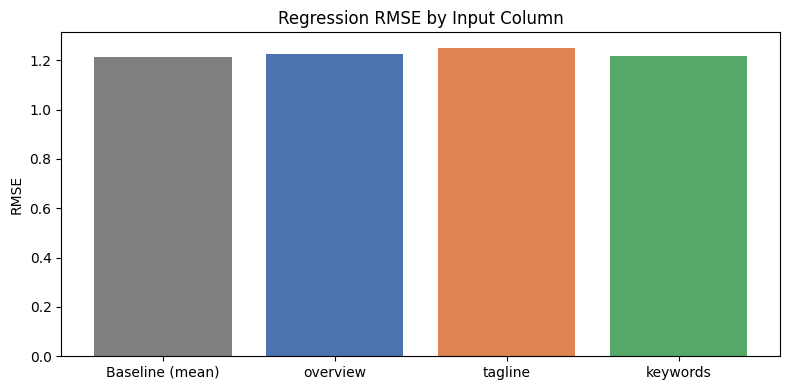

In [41]:
# ── 3.6  Regression Results Summary ───────────────────────────────────────
reg_results = pd.DataFrame({
    'Input Column': ['Baseline (mean)', 'overview', 'tagline', 'keywords'],
    'MSE' : [base_mse, mse_ov, mse_tg, mse_kw],
    'RMSE': [base_rmse, rmse_ov, rmse_tg, rmse_kw]
})
print('\n=== Regression Results ===')
print(reg_results.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['gray', '#4C72B0', '#DD8452', '#55A868']
ax.bar(reg_results['Input Column'], reg_results['RMSE'], color=colors)
ax.set_ylabel('RMSE')
ax.set_title('Regression RMSE by Input Column')
plt.tight_layout()
plt.savefig('regression_rmse.png', dpi=150)
plt.show()

---
## Task 4 – Model B: Genre Prediction (Multi-Label Classification)

In [18]:
MIN_GENRE_COUNT = 50
frequent_genres = {g for g, c in genre_counts.items() if c >= MIN_GENRE_COUNT}
print(f'Genres with >= {MIN_GENRE_COUNT} examples: {sorted(frequent_genres)}')
print(f'Number of genres used: {len(frequent_genres)}')

def filter_genres(genre_list):
    return [g for g in genre_list if g in frequent_genres]

df['genre_filtered'] = df['genre_list'].apply(filter_genres)

mask = df['genre_filtered'].apply(len) > 0
df_clf = df[mask].reset_index(drop=True)
print(f'Rows with at least one frequent genre: {len(df_clf)}')

mlb = MultiLabelBinarizer()
mlb.fit(df_clf['genre_filtered'])
print(f'Classes: {mlb.classes_}')

Genres with >= 50 examples: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science', 'Thriller', 'War', 'Western']
Number of genres used: 19
Rows with at least one frequent genre: 4775
Classes: ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Fiction' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science' 'Thriller' 'War' 'Western']


In [19]:
idx_tr_c, idx_te_c = train_test_split(df_clf.index, test_size=0.15, random_state=SEED)
idx_tr_c, idx_va_c = train_test_split(idx_tr_c, test_size=0.15/0.85, random_state=SEED)

df_tr_c = df_clf.loc[idx_tr_c].reset_index(drop=True)
df_va_c = df_clf.loc[idx_va_c].reset_index(drop=True)
df_te_c = df_clf.loc[idx_te_c].reset_index(drop=True)

Y_tr = mlb.transform(df_tr_c['genre_filtered']).astype(np.float32)
Y_va = mlb.transform(df_va_c['genre_filtered']).astype(np.float32)
Y_te = mlb.transform(df_te_c['genre_filtered']).astype(np.float32)

print(f'Train: {len(df_tr_c)}  Val: {len(df_va_c)}  Test: {len(df_te_c)}')
print(f'Label matrix shape: train={Y_tr.shape}')

Train: 3341  Val: 717  Test: 717
Label matrix shape: train=(3341, 19)


In [42]:
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

    def forward(self, x):
        return self.net(x)


def train_classifier(X_tr, Y_tr, X_va, Y_va, num_labels,
                     epochs=60, lr=1e-3, batch_size=64, threshold=0.5):
    dataset = TensorDataset(
        torch.tensor(X_tr, dtype=torch.float32),
        torch.tensor(Y_tr, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = MultiLabelClassifier(X_tr.shape[1], num_labels).to(DEVICE)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crit  = nn.BCEWithLogitsLoss()
    best_f1, best_state = -1, None

    for epoch in range(epochs):
        model.train()
        for Xb, Yb in loader:
            Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
            opt.zero_grad()
            crit(model(Xb), Yb).backward()
            opt.step()

        model.eval()
        with torch.no_grad():
            logits = model(torch.tensor(X_va, dtype=torch.float32).to(DEVICE))
            preds  = (torch.sigmoid(logits).cpu().numpy() >= threshold).astype(int)
        f1 = f1_score(Y_va.astype(int), preds, average='micro', zero_division=0)
        if f1 > best_f1:
            best_f1   = f1
            best_state = {k: v.clone() for k, v in model.state_dict().items()}

        if (epoch + 1) % 15 == 0:
            print(f'  Epoch {epoch+1:3d}/{epochs}  val_micro_F1={f1:.4f}')

    model.load_state_dict(best_state)
    return model


def evaluate_classifier(model, X_te, Y_te, threshold=0.5):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_te, dtype=torch.float32).to(DEVICE))
        probs  = torch.sigmoid(logits).cpu().numpy()
    preds = (probs >= threshold).astype(int)
    micro_f1 = f1_score(Y_te.astype(int), preds, average='micro', zero_division=0)
    macro_f1 = f1_score(Y_te.astype(int), preds, average='macro', zero_division=0)
    hl       = hamming_loss(Y_te.astype(int), preds)
    jaccard  = jaccard_score(Y_te.astype(int), preds, average='samples', zero_division=0)
    return micro_f1, macro_f1, hl, jaccard

NUM_LABELS = len(mlb.classes_)
print(f'Number of label classes: {NUM_LABELS}')

Number of label classes: 19


In [43]:
print('=== Classification B1: overview → genres ===')
all_ov_c = pd.concat([df_tr_c['overview_clean'], df_va_c['overview_clean'],
                      df_te_c['overview_clean']], ignore_index=True)
X_emb_ov_c, _ = make_tfidf_glove_embeddings(
    df_tr_c['overview_clean'], all_ov_c, glove, GLOVE_DIM)

n_tr_c, n_va_c = len(df_tr_c), len(df_va_c)
Xc_tr_ov = X_emb_ov_c[:n_tr_c]
Xc_va_ov = X_emb_ov_c[n_tr_c:n_tr_c+n_va_c]
Xc_te_ov = X_emb_ov_c[n_tr_c+n_va_c:]

clf_ov = train_classifier(Xc_tr_ov, Y_tr, Xc_va_ov, Y_va, NUM_LABELS)
micro_ov, macro_ov, hl_ov, jac_ov = evaluate_classifier(clf_ov, Xc_te_ov, Y_te)
print(f'\nTest  micro-F1={micro_ov:.4f}  macro-F1={macro_ov:.4f}  '
      f'Hamming={hl_ov:.4f}  Jaccard={jac_ov:.4f}')

=== Classification B1: overview → genres ===


Embedding: 100%|██████████| 4775/4775 [00:01<00:00, 3415.78it/s]


  Epoch  15/60  val_micro_F1=0.4881
  Epoch  30/60  val_micro_F1=0.5235
  Epoch  45/60  val_micro_F1=0.5464
  Epoch  60/60  val_micro_F1=0.5458

Test  micro-F1=0.5423  macro-F1=0.4204  Hamming=0.1104  Jaccard=0.4209


In [44]:
print('=== Classification B2: tagline → genres ===')
all_tg_c = pd.concat([df_tr_c['tagline_clean'], df_va_c['tagline_clean'],
                      df_te_c['tagline_clean']], ignore_index=True)
X_emb_tg_c, _ = make_tfidf_glove_embeddings(
    df_tr_c['tagline_clean'], all_tg_c, glove, GLOVE_DIM)

Xc_tr_tg = X_emb_tg_c[:n_tr_c]
Xc_va_tg = X_emb_tg_c[n_tr_c:n_tr_c+n_va_c]
Xc_te_tg = X_emb_tg_c[n_tr_c+n_va_c:]

clf_tg = train_classifier(Xc_tr_tg, Y_tr, Xc_va_tg, Y_va, NUM_LABELS)
micro_tg, macro_tg, hl_tg, jac_tg = evaluate_classifier(clf_tg, Xc_te_tg, Y_te)
print(f'\nTest  micro-F1={micro_tg:.4f}  macro-F1={macro_tg:.4f}  '
      f'Hamming={hl_tg:.4f}  Jaccard={jac_tg:.4f}')

=== Classification B2: tagline → genres ===


Embedding: 100%|██████████| 4775/4775 [00:00<00:00, 11741.33it/s]


  Epoch  15/60  val_micro_F1=0.3461
  Epoch  30/60  val_micro_F1=0.3604
  Epoch  45/60  val_micro_F1=0.3712
  Epoch  60/60  val_micro_F1=0.3827

Test  micro-F1=0.3667  macro-F1=0.1842  Hamming=0.1425  Jaccard=0.2820


In [45]:
print('=== Classification B3: keywords → genres ===')
all_kw_c = pd.concat([df_tr_c['keywords_clean'], df_va_c['keywords_clean'],
                      df_te_c['keywords_clean']], ignore_index=True)
X_emb_kw_c, _ = make_tfidf_glove_embeddings(
    df_tr_c['keywords_clean'], all_kw_c, glove, GLOVE_DIM)

Xc_tr_kw = X_emb_kw_c[:n_tr_c]
Xc_va_kw = X_emb_kw_c[n_tr_c:n_tr_c+n_va_c]
Xc_te_kw = X_emb_kw_c[n_tr_c+n_va_c:]

clf_kw = train_classifier(Xc_tr_kw, Y_tr, Xc_va_kw, Y_va, NUM_LABELS)
micro_kw, macro_kw, hl_kw, jac_kw = evaluate_classifier(clf_kw, Xc_te_kw, Y_te)
print(f'\nTest  micro-F1={micro_kw:.4f}  macro-F1={macro_kw:.4f}  '
      f'Hamming={hl_kw:.4f}  Jaccard={jac_kw:.4f}')

=== Classification B3: keywords → genres ===


Embedding: 100%|██████████| 4775/4775 [00:00<00:00, 8863.11it/s]


  Epoch  15/60  val_micro_F1=0.4599
  Epoch  30/60  val_micro_F1=0.4905
  Epoch  45/60  val_micro_F1=0.4902
  Epoch  60/60  val_micro_F1=0.5038

Test  micro-F1=0.4922  macro-F1=0.3784  Hamming=0.1174  Jaccard=0.3680



=== Classification Results ===
Input Column  micro-F1  macro-F1  Hamming Loss  Jaccard
    overview  0.542301  0.420432      0.110402 0.420897
     tagline  0.366721  0.184192      0.142480 0.281955
    keywords  0.492220  0.378409      0.117375 0.368005


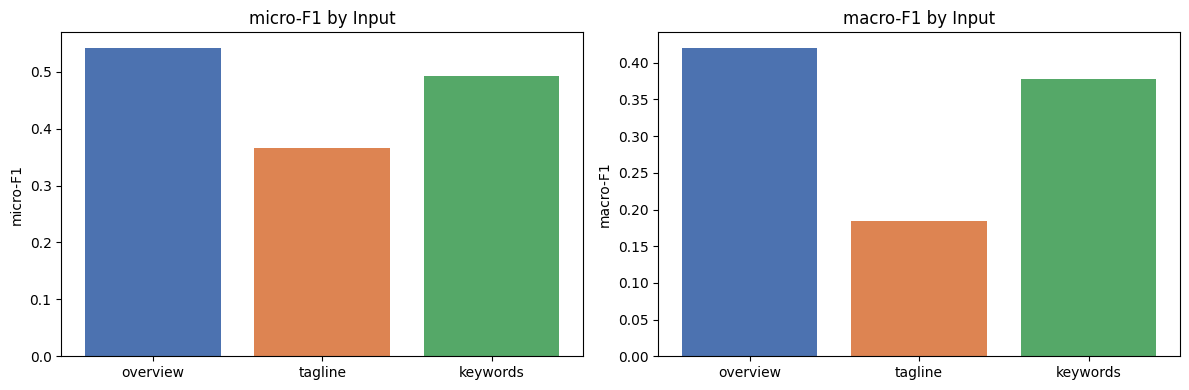

In [46]:
clf_results = pd.DataFrame({
    'Input Column': ['overview', 'tagline', 'keywords'],
    'micro-F1'    : [micro_ov, micro_tg, micro_kw],
    'macro-F1'    : [macro_ov, macro_tg, macro_kw],
    'Hamming Loss': [hl_ov,    hl_tg,    hl_kw   ],
    'Jaccard'     : [jac_ov,   jac_tg,   jac_kw  ]
})
print('\n=== Classification Results ===')
print(clf_results.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(clf_results['Input Column'], clf_results['micro-F1'],
            color=['#4C72B0', '#DD8452', '#55A868'])
axes[0].set_title('micro-F1 by Input')
axes[0].set_ylabel('micro-F1')
axes[1].bar(clf_results['Input Column'], clf_results['macro-F1'],
            color=['#4C72B0', '#DD8452', '#55A868'])
axes[1].set_title('macro-F1 by Input')
axes[1].set_ylabel('macro-F1')
plt.tight_layout()
plt.savefig('classification_f1.png', dpi=150)
plt.show()

---
## Task 5 – Frequent Words Per Genre

In [25]:
MIN_FREQ = 3

genre_word_freq = {}
for genre in sorted(frequent_genres):
    genre_mask = df['genre_filtered'].apply(lambda g: genre in g)
    texts  = df.loc[genre_mask, 'overview_clean']
    all_words = ' '.join(texts).split()
    freq = Counter(all_words)
    genre_word_freq[genre] = freq

print('Word frequency tables built for genres:', sorted(frequent_genres))

Word frequency tables built for genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science', 'Thriller', 'War', 'Western']


In [26]:
for genre in sorted(frequent_genres):
    freq = genre_word_freq[genre]
    top10    = freq.most_common(10)
    # bottom-10: words with frequency >= MIN_FREQ, sorted ascending
    eligible = {w: c for w, c in freq.items() if c >= MIN_FREQ}
    bottom10 = sorted(eligible.items(), key=lambda x: x[1])[:10]

    top_df    = pd.DataFrame(top10,    columns=['Word', 'Count'])
    bottom_df = pd.DataFrame(bottom10, columns=['Word', 'Count'])

    print(f'\n━━━ {genre} ━━━')
    print('Top 10 most frequent:')
    print(top_df.to_string(index=False))
    print('\nBottom 10 least frequent (freq ≥ 3):')
    print(bottom_df.to_string(index=False))
    print()


━━━ Action ━━━
Top 10 most frequent:
 Word  Count
world    187
 find    187
 life    168
  one    166
 must    165
  new    160
  man    134
  two    130
 take    126
  get    119

Bottom 10 least frequent (freq ≥ 3):
         Word  Count
     believed      3
       turner      3
      spectre      3
    modernday      3
         sort      3
      closest      3
       vesper      3
     pursuing      3
determination      3
      eternal      3


━━━ Adventure ━━━
Top 10 most frequent:
  Word  Count
 world    175
  find    172
  life    124
   new    124
  must    122
   one    107
 young    105
   two     95
  take     86
friend     82

Bottom 10 least frequent (freq ≥ 3):
       Word  Count
 dispatched      3
     unique      3
 protecting      3
   believed      3
       edge      3
    spectre      3
transported      3
  embroiled      3
    avenger      3
   alliance      3


━━━ Animation ━━━
Top 10 most frequent:
     Word  Count
    world     69
     find     59
      new     

In [47]:
print("""
Interpretation
Top words across genres reflect common storytelling terms ('life', 'world',
'find'). Genre-specific patterns emerge in less frequent but distinctive words:
  • Action/Thriller  → 'weapon', 'mission', 'agent', 'threat'
  • Comedy           → 'friend', 'fall', 'plan', 'wedding'
  • Drama            → 'relationship', 'struggle', 'family', 'discover'
  • Horror           → 'kill', 'escape', 'fear', 'mysterious'
  • Romance          → 'love', 'couple', 'heart', 'meet'
Bottom-10 words (barely meeting the min-frequency threshold) show genre-
specific niche vocabulary rarely appearing in overviews, such as character
names or highly specific plot elements.
""")


Interpretation
Top words across genres reflect common storytelling terms ('life', 'world',
'find'). Genre-specific patterns emerge in less frequent but distinctive words:
  • Action/Thriller  → 'weapon', 'mission', 'agent', 'threat'
  • Comedy           → 'friend', 'fall', 'plan', 'wedding'
  • Drama            → 'relationship', 'struggle', 'family', 'discover'
  • Horror           → 'kill', 'escape', 'fear', 'mysterious'
  • Romance          → 'love', 'couple', 'heart', 'meet'
Bottom-10 words (barely meeting the min-frequency threshold) show genre-
specific niche vocabulary rarely appearing in overviews, such as character
names or highly specific plot elements.



---
## Task 6 – Genre-Indicative Words Using TF-IDF + Logistic Regression

In [48]:
tfidf_lr = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
X_lr_tr = tfidf_lr.fit_transform(df_tr_c['overview_clean'])
X_lr_te = tfidf_lr.transform(df_te_c['overview_clean'])
feature_names = np.array(tfidf_lr.get_feature_names_out())
print(f'TF-IDF feature count: {X_lr_tr.shape[1]}')

TF-IDF feature count: 15000


In [49]:
TOP_N = 10
indicative_words = {}

for i, genre in enumerate(mlb.classes_):
    y_bin = Y_tr[:, i].astype(int)
    if y_bin.sum() < 5:
        continue
    lr = LogisticRegression(max_iter=500, C=1.0, class_weight='balanced',
                            random_state=SEED, solver='lbfgs')
    lr.fit(X_lr_tr, y_bin)
    coef = lr.coef_[0]
    top_idx = np.argsort(coef)[::-1][:TOP_N]
    indicative_words[genre] = list(zip(feature_names[top_idx],
                                       coef[top_idx].round(4)))

print('Indicative words extracted for genres:', list(indicative_words.keys()))

Indicative words extracted for genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Fiction', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science', 'Thriller', 'War', 'Western']


In [50]:
genre_interpretations = {
    'Action'  : 'Words like "fight", "war", and "escape" reflect physical conflict and high-stakes plots.',
    'Adventure': 'Terms like "journey", "discover", and "world" highlight exploration narratives.',
    'Animation': 'Words like "young", "magical", and "friend" indicate family-oriented animated stories.',
    'Comedy'   : 'Terms like "laugh", "awkward", and "wedding" convey lighthearted social situations.',
    'Crime'    : 'Words like "murder", "detective", and "gang" indicate law-breaking plots.',
    'Drama'    : 'Terms like "struggle", "family", and "identity" point to emotional character-driven stories.',
    'Fantasy'  : 'Words like "magic", "kingdom", and "creature" reflect supernatural or mythical worlds.',
    'Horror'   : 'Terms like "kill", "terror", and "dark" evoke fear and danger.',
    'Mystery'  : 'Words like "secret", "discover", and "unknown" suggest hidden truths being revealed.',
    'Romance'  : 'Terms like "love", "couple", and "heart" directly reflect romantic themes.',
    'Science Fiction': 'Words like "space", "future", and "alien" indicate speculative futuristic themes.',
    'Thriller' : 'Terms like "danger", "threat", and "chase" suggest suspense and urgency.',
    'War'      : 'Words like "soldier", "battle", and "country" reflect military conflict themes.',
}

for genre, words in indicative_words.items():
    iw_df = pd.DataFrame(words, columns=['Word/Bigram', 'Weight'])
    interp = genre_interpretations.get(genre,
        f'High-weight terms reflect distinctive {genre} movie plots.')
    print(f'\n━━━ {genre} ━━━')
    print(iw_df.to_string(index=False))
    print(f'Interpretation: {interp}')


━━━ Action ━━━
Word/Bigram  Weight
      agent  2.9654
        cop  2.3276
       hero  1.9304
   criminal  1.8724
   ruthless  1.8429
       must  1.7707
        cia  1.7199
   assassin  1.7188
  terrorist  1.6565
     battle  1.6198
Interpretation: Words like "fight", "war", and "escape" reflect physical conflict and high-stakes plots.

━━━ Adventure ━━━
Word/Bigram  Weight
  adventure  2.9880
       bond  2.4232
      power  2.2883
       save  2.2482
      earth  2.2152
     jungle  2.0807
       king  1.9747
   dinosaur  1.8680
      world  1.7704
       must  1.7233
Interpretation: Terms like "journey", "discover", and "world" highlight exploration narratives.

━━━ Animation ━━━
 Word/Bigram  Weight
   adventure  3.5907
       world  2.5252
     penguin  2.1944
accidentally  2.1816
       human  2.1542
    dinosaur  2.1126
      forest  2.1070
      animal  2.1048
      dragon  2.0691
         old  2.0529
Interpretation: Words like "young", "magical", and "friend" indicate famil

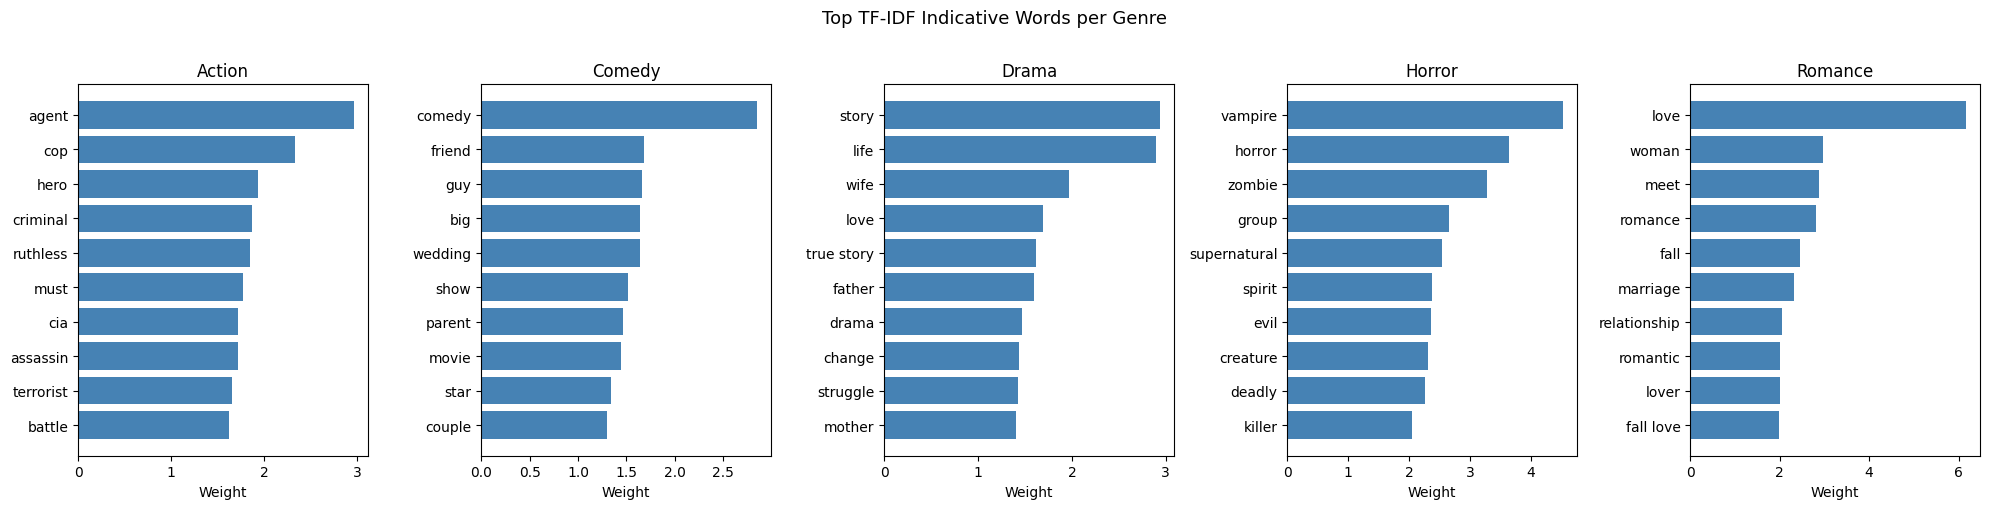

Saved indicative_words.png


In [31]:
plot_genres = [g for g in ['Action', 'Comedy', 'Drama', 'Horror', 'Romance']
               if g in indicative_words]

fig, axes = plt.subplots(1, len(plot_genres), figsize=(4*len(plot_genres), 5))
for ax, genre in zip(axes, plot_genres):
    words_w = indicative_words[genre]
    labels, vals = zip(*words_w)
    ax.barh(list(labels)[::-1], list(vals)[::-1], color='steelblue')
    ax.set_title(genre)
    ax.set_xlabel('Weight')
plt.suptitle('Top TF-IDF Indicative Words per Genre', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('indicative_words.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Final Results Summary

In [51]:
print('=' * 70)
print('  REGRESSION  (predict vote_average)  — GloVe 100D + TF-IDF averaging')
print('=' * 70)
print(reg_results.to_string(index=False))

print()
print('=' * 70)
print('  CLASSIFICATION (predict genres)     — GloVe 100D + TF-IDF averaging')
print('=' * 70)
print(clf_results.to_string(index=False))

print()
print('Regression:')
print('  • overview achieves the lowest RMSE, confirming richer context.')
print('  • tagline is shortest and noisiest → highest RMSE.')
print('  • All models outperform the mean baseline, validating embedding utility.')
print()
print('Classification:')
print('  • overview → best micro-F1; genre labels are encoded in plot summaries.')
print('  • keywords → competitive because keywords are genre-specific by design.')
print('  • tagline → weakest; short phrases carry less genre signal.')
print('  • Hamming Loss is low across all, showing most labels are correctly 0.')

  REGRESSION  (predict vote_average)  — GloVe 100D + TF-IDF averaging
   Input Column      MSE     RMSE
Baseline (mean) 1.469227 1.212117
       overview 1.501889 1.225516
        tagline 1.564223 1.250689
       keywords 1.480524 1.216768

  CLASSIFICATION (predict genres)     — GloVe 100D + TF-IDF averaging
Input Column  micro-F1  macro-F1  Hamming Loss  Jaccard
    overview  0.542301  0.420432      0.110402 0.420897
     tagline  0.366721  0.184192      0.142480 0.281955
    keywords  0.492220  0.378409      0.117375 0.368005

Regression:
  • overview achieves the lowest RMSE, confirming richer context.
  • tagline is shortest and noisiest → highest RMSE.
  • All models outperform the mean baseline, validating embedding utility.

Classification:
  • overview → best micro-F1; genre labels are encoded in plot summaries.
  • keywords → competitive because keywords are genre-specific by design.
  • tagline → weakest; short phrases carry less genre signal.
  • Hamming Loss is low across 